# Yaw angle optimisation
Calculating the optimum yaw angle for turbines across a range of wakes and wind speeds

## To do
- Choose optimisation method
    - Speed
    - Convergence criteria control
- Increase fidelity
    - Assess difference in speed of calculation and optimal values
- Loop over wind direction
    - Parallelise using PQDM
- Assess results
    - Sensitivity to wind direction/speed
    - Variation in sensitivity between turbines
    - Increase number of turbines

## Setup

In [1]:
# import libraries
import logging
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy import optimize
from tqdm.notebook import tqdm

import utils

In [2]:
# define constants
yaw_scale = 30

## Baseline values

In [3]:
# run baseline simulation
sim_res_base = utils.run_sim()

In [4]:
# cut in speed
cut_in_index = np.argmax(
    sim_res_base.windFarmModel.windTurbines.power(sim_res_base.ws) > 0
)
cut_in_speed = sim_res_base.ws[cut_in_index].values.tolist()

In [5]:
# ensure probabilities (wind direction and speed) total 1
Sector_frequency = sim_res_base.Sector_frequency
if not np.isclose(Sector_frequency.sum(), 1):
    logging.warning(
        f"Sector frequency renormalised as total probability was {Sector_frequency.sum().values}"
    )
    Sector_frequency = Sector_frequency / Sector_frequency.sum()
P = sim_res_base.P
if not np.isclose(P.sum(), 1):
    logging.warning(f"P renormalised as total probability was {P.sum().values}")
    P = P / P.sum()

In [6]:
# calculate baseline metrics
aep_base, lcoe_base, cap_fac_base = utils.calc_metrics(
    sim_res=sim_res_base,
    sim_res_base=sim_res_base,
    Sector_frequency=Sector_frequency,
    P=P,
    show=True,
)
(
    lcoe_direction_base,
    cap_fac_direction_base,
    lcoe_overall_base,
    cap_fac_overall_base,
) = utils.aggregate_metrics(
    aep=aep_base,
    lcoe=lcoe_base,
    cap_fac=cap_fac_base,
    Sector_frequency=Sector_frequency,
)

AEP [GWh]: 79.174
LCoE [USD/MWh]: 44.477
Capacity factor [%]: 50.177


## Optimise across for a single wind direction

In [7]:
# define constants
wd = 270
yaw_shape = (len(sim_res_base.wt), 1, len(sim_res_base.ws))

In [8]:
# initialise optimal yaw dataset
yaw_opt = xr.Dataset(
    data_vars={
        "lcoe": (["wt", "wd", "ws"], np.zeros(yaw_shape)),
        "power": (["wt", "wd", "ws"], np.zeros(yaw_shape)),
    },
    coords={
        "wt": list(sim_res_base.wt.values),
        "wd": [wd],
        "ws": list(sim_res_base.ws.values),
    },
)

In [9]:
# optimise for power output indepedently across wind speeds
next_x0 = np.ones(len(sim_res_base.wt)) / yaw_scale
for ws in tqdm(sim_res_base.ws.values):
    if ws >= cut_in_speed:
        # define objective function for power
        def obj_power_single(yaw_norm):
            sim_res = utils.run_sim(yaw=yaw_norm * yaw_scale, ws=ws, wd=wd)
            obj = -(
                sim_res.Power.sel(ws=ws, wd=wd).sum("wt")
                / sim_res_base.Power.sel(ws=ws, wd=wd).sum("wt")
            ).values.tolist()
            return obj

        assert np.isclose(obj_power_single(np.zeros(len(sim_res_base.wt))), -1)
        # optimise power output
        res = optimize.minimize(fun=obj_power_single, x0=next_x0)
        # process results
        next_x0 = res.x
        yaw_opt.power.loc[:, wd, ws] = res.x * yaw_scale

  0%|          | 0/31 [00:00<?, ?it/s]

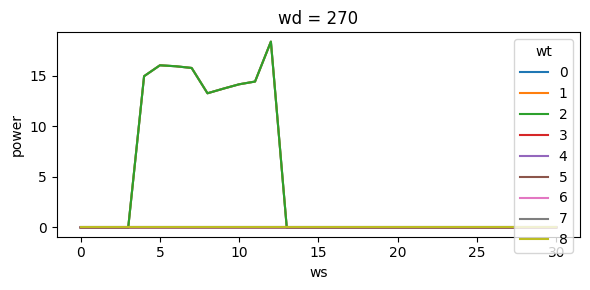

In [10]:
# plot optimum yaw angles based on power
fig, ax = plt.subplots(figsize=(6, 3))
yaw_opt.power.sel(wd=wd).plot.line(hue="wt")
fig.tight_layout()

In [11]:
# define objective function for lcoe
def obj_lcoe_single(yaw_norm):
    sim_res = utils.run_sim(yaw=yaw_norm.reshape(yaw_shape) * yaw_scale, wd=wd)
    aep, lcoe, _ = utils.calc_metrics(
        sim_res=sim_res,
        sim_res_base=sim_res_base,
        Sector_frequency=Sector_frequency,
        P=P,
    )
    _, _, lcoe_overall, _ = utils.aggregate_metrics(
        aep=aep, lcoe=lcoe, Sector_frequency=Sector_frequency
    )
    obj = (lcoe_overall / lcoe_direction_base.sel(wd=wd)).values.tolist()
    return obj


assert np.isclose(obj_lcoe_single(np.zeros(yaw_shape).ravel()), 1)

In [28]:
# define optimisation callback
def _callback(intermediate_result):
    global n
    if n % 25 == 0:
        print(f"Iteration {n:3.0f}: obj = {intermediate_result.fun:.5f}")
    n += 1

In [31]:
# trial different optimisers
method_results = {}
for method in tqdm(
    [
        "Nelder-Mead",
        "Powell",
        "CG",
        "BFGS",
        # "Newton-CG",
        "L-BFGS-B",
        "TNC",
        "COBYLA",
        "SLSQP",
        "trust-constr",
        # "dogleg",
        # "trust-ncg",
        # "trust-exact",
        "trust-krylov",
    ]
):
    try:
        n = 0
        st = time.time()
        res = optimize.minimize(
            fun=obj_lcoe_single,
            x0=yaw_opt.power.values.ravel() / yaw_scale,
            method=method,
            # callback=_callback
        )
        method_results[method] = {"time": time.time() - st, "obj": res.fun}
    except Exception as e:
        print(e)
    res

  0%|          | 0/13 [00:00<?, ?it/s]

Jacobian is required for dogleg minimization
Jacobian is required for Newton-CG trust-region minimization
Jacobian is required for trust region exact minimization.
('Jacobian is required for trust region ', 'exact minimization.')


In [33]:
pd.DataFrame(method_results).T.sort_values("obj")

,time,obj
Powell,97.708798,0.9921579124363608
trust-constr,664.996147,0.992158
COBYLA,31.903464,0.992239
Nelder-Mead,231.970223,0.992264
CG,49.182255,0.992264
L-BFGS-B,16.378526,0.992264
BFGS,46.181047,0.992264
TNC,245.733027,0.992264
SLSQP,3.282698,0.99227


In [ ]:
# run optimisation with iteration counter display
n = 0
res = optimize.minimize(
    fun=obj_lcoe_single, x0=yaw_opt.power.values.ravel() / yaw_scale, callback=_callback
)
yaw_opt.lcoe.loc[:, :, :] = res.x.reshape(yaw_shape) * yaw_scale
res

In [ ]:
# plot optimum yaw angles
fig, ax = plt.subplots(figsize=(6, 3))
yaw_opt.lcoe.sel(wd=wd).plot.line(hue="wt")
fig.tight_layout()

In [ ]:
# rerun simulation for optimum
sim_res_opt = utils.run_sim(yaw=yaw_opt.lcoe.values.reshape(yaw_shape), wd=wd)
aep_opt, lcoe_opt, cap_fac_opt = utils.calc_metrics(
    sim_res=sim_res_opt,
    sim_res_base=sim_res_base,
    Sector_frequency=Sector_frequency,
    P=P,
)
_, _, lcoe_overall_opt, cap_fac_overall_opt = utils.aggregate_metrics(
    aep=aep_opt, lcoe=lcoe_opt, cap_fac=cap_fac_opt, Sector_frequency=Sector_frequency
)

In [ ]:
# display comaprison of optimum to baseline
print(f"Baseline LCoE [USD/MWh]      : {lcoe_direction_base.sel(wd=wd).values:.3f}")
print(f"Optimum LCoE [USD/MWh]       : {lcoe_overall_opt.values:.3f}")
print(
    f"Baseline Capacity Factor [%] : {100*cap_fac_direction_base.sel(wd=wd).values:.3f}"
)
print(f"Optimum Capacity Factor [%]  : {100*cap_fac_overall_opt.values:.3f}")